In [ ]:
from mlxtend.data import loadlocal_mnist
import torch
import numpy as np
import time

import torch.nn.functional as F
from torch.autograd import Variable

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset,TensorDataset
import matplotlib.pyplot as plt
%matplotlib inline

### Fonctions utiles afin de simplifer l'implémentation
en effet, la plupart des oppérations sont similaires, à l'utilisation d'un BatchNorm près

In [ ]:
def dconv(in_, out, kernel, stride=2, padding=1, batch_norm=True):
    l = []
    l.append(nn.ConvTranspose2d(in_, out, kernel, stride, padding, bias=False))
    if batch_norm:
        l.append(nn.BatchNorm2d(out))
    return nn.Sequential(*l)

def conv(in_, out, kernel, stride=2, padding=1, batch_norm=True):
    l = []
    l.append(nn.Conv2d(in_, out, kernel, stride, padding, bias=False))
    if batch_norm:
        l.append(nn.BatchNorm2d(out))
    return nn.Sequential(*l)

### Réseaux de neurones pour les générateurs et discriminateurs

In [ ]:
class DMNIST(nn.Module):
    """MNIST discriminateur"""
    def __init__(self, conv_dim=28, use_labels=False):
        super(DMNIST, self).__init__()
        self.conv1 = conv(1, 28, kernel=5, stride=2, padding=0, batch_norm=False)
        self.conv2 = conv(28, 56,kernel=5, stride=2, padding=1)
        self.conv3 = conv(56, 112, kernel=2, stride=2, padding=0)
        self.conv4 = conv(112, 1, kernel=2, stride=2, padding=0, batch_norm=False)
        
    def forward(self, x):
        out = F.relu(self.conv1(x))    
        out = F.relu(self.conv2(out))  
        out = F.relu(self.conv3(out))
        out = self.conv4(out) 
        return out.squeeze()

In [ ]:
class DUSPS(nn.Module):
    """USPS discriminateur"""
    def __init__(self):
        super(DUSPS, self).__init__()
        self.conv1 = conv(1,  16, kernel=4, stride=2, padding=1, batch_norm=False)
        self.conv2 = conv(16, 32, kernel=4, stride=2, padding=1)
        self.conv3 = conv(32, 64,kernel=2, stride=2, padding=0)
        self.conv4 = conv(64, 1, kernel=2, stride=2, padding=0, batch_norm=False)
        
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out)) 
        out = self.conv4(out)
        return out.squeeze()

In [ ]:
class GMNISTUSPS(nn.Module):
    """MNIST --- > USPS"""
    def __init__(self, conv_dim=16):
        super(GMNISTUSPS, self).__init__()

        # encoding
        self.conv1 = conv(1, 8, 4, 1, 0)
        self.conv2 = conv(8, 16, 5, 2, 0)
        self.conv3 = conv(16, 32, 5, 2, 0, False)        
        
        # resnet
        self.conv4 = conv(32, 32, 3, 1, 1)
        self.conv5 = conv(32, 32, 3, 1, 1)

        
        # decoding
        self.dconv1 = dconv(32, 16, 5, 2,0)
        self.dconv2 = dconv(16, 8, 4,1,0)
        self.dconv3 = dconv(8, 1, 3, 1, 0, False)
        
    def forward(self, x):
        out = F.relu(self.conv1(x)) 
        out = F.relu(self.conv2(out)) 
        out = self.conv3(out)

        out = self.conv4(out)
        out = F.relu(self.conv5(out))

        out = F.relu(self.dconv1(out)) 
        out = F.relu(self.dconv2(out))
        out = self.dconv3(out)
        return torch.tanh(out)

In [ ]:
class GUSPSMNIST(nn.Module):
    """USPS --- > MNIST"""
    def __init__(self, conv_dim=16):
        super(GUSPSMNIST, self).__init__()
        # encoding
        self.conv1 = conv(1, 8, 3, 1, 0)
        self.conv2 = conv(8, 16, 4, 1,0)
        self.conv3 = conv(16, 32, 5, 2, 0 ,False)
        
        
        # resnet
        self.conv4 = conv(32, 32, 3,1, 1)
        self.conv5 = conv(32, 32, 3,1, 1)

        
        # decoding
        self.dconv1 = dconv(32, 16, 5, 2, 0)
        self.dconv2 = dconv(16, 8, 5, 2, 0)
        self.dconv3 = dconv(8, 1, 4, 1, 0, batch_norm=False)

        
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out) )
        out = self.conv3(out)

        out = self.conv4(out)
        out = F.relu(self.conv5(out))

        out = F.relu(self.dconv1(out))
        out = F.relu(self.dconv2(out))
        out = torch.tanh(self.dconv3(out))
        return out

### Récupération et mise en forme des données

In [ ]:
X, y = loadlocal_mnist(
        images_path='./MNIST_train_im', 
        labels_path='./MNIST_train_label')
X = X/254

In [ ]:
import h5py
with h5py.File("./usps.h5", 'r') as hf:
        train = hf.get('train')
        X_tr = train.get('data')[:]
        y_tr = train.get('target')[:]
        test = hf.get('test')
        X_te = test.get('data')[:]
        y_te = test.get('target')[:]

In [ ]:
x = np.expand_dims(X.reshape(60000,28,28), 1)
tensor_x_1 = torch.from_numpy(x.astype("float32")) # transform to torch tensor
tensor_y_1 = torch.from_numpy(y.astype("float32"))
tensor_x_2 = torch.from_numpy(X_tr.reshape(7291,1,16,16).astype("float32"))
tensor_y_2 = torch.from_numpy(y_tr.astype("float32"))
my_dataset_1 = TensorDataset(tensor_x_1,tensor_y_1)# create your datset
my_dataset_2 = TensorDataset(tensor_x_2,tensor_y_2)


In [ ]:
class_inds_1 = [torch.where(my_dataset_1.tensors[1] == i)[0]
              for i in range(10)]
class_inds_2 = [torch.where(my_dataset_2.tensors[1] == i)[0]
              for i in range(10)]

In [ ]:
dataloaders_1 = [
    DataLoader(
        dataset=Subset(my_dataset_1, class_inds_1[i]),
        batch_size=64,
        shuffle=True,
        drop_last=False)
    for i in range(10)]

dataloaders_2 = [
    DataLoader(
        dataset=Subset(my_dataset_2, class_inds_2[i]),
        batch_size=64,
        shuffle=True,
        drop_last=False)
    for i in range(10)]

### Procédure d'entrainement

In [ ]:
def train(usps_loader, mnist_loader):
    lambda_ = 0.0002

    G_params = list(GMU.parameters()) + list(GUM.parameters())
    D_params = list(DM.parameters()) + list(DU.parameters())

    G_optimizer = optim.Adam(G_params, lambda_)

    D_optimizer = optim.Adam(D_params, lambda_)


    usps_iter = iter(usps_loader)
    mnist_iter = iter(mnist_loader)
    iter_per_epoch = min(len(usps_iter), len(mnist_iter))

    fixusps = Variable(usps_iter.next()[0].cuda())
    fixmnist = Variable(mnist_iter.next()[0].cuda())

    criterion = nn.CrossEntropyLoss()

    for step in range((epochs+1) *iter_per_epoch ):
        if (step+1) % iter_per_epoch == 0:
            if (step+1) / iter_per_epoch -2 > epochs/2:
                lambda_ = lambda_ - 0.0002 / (epochs/2)
                G_params = list(GMU.parameters()) + list(GUM.parameters())
                D_params = list(DM.parameters()) + list(DU.parameters())

                G_optimizer = optim.Adam(G_params, lambda_)
                D_optimizer = optim.Adam(D_params, lambda_)
        mnist_iter = iter(mnist_loader)
        usps_iter = iter(usps_loader)

        # load svhn and mnist dataset
        usps, s_labels = usps_iter.next() 
        usps = Variable(usps.cuda())
        s_labels = Variable(s_labels.cuda()).long().squeeze()
        mnist, m_labels = mnist_iter.next() 
        mnist = Variable(mnist.cuda())
        m_labels = Variable(m_labels.cuda())


        #Entrainement Discriminateurs#

        #REAL#

        out = DM(mnist)

        DM_loss = torch.mean((out-1)**2)

        out = DU(usps)

        DU_loss = torch.mean((out-1)**2)



        D_real_loss = DM_loss + DU_loss
        D_real_loss.backward()
        D_optimizer.step()



        #FAKE#

        D_optimizer.zero_grad()
        G_optimizer.zero_grad()

        fake_usps = GMU(mnist)

        out = DU(fake_usps).
        DU_loss = torch.mean((out)**2)

        f_mnist = GUM(usps)
        out = DM(f_mnist)

        DM_loss = torch.mean((out)**2)

        D_fake_loss = DU_loss + DM_loss
        D_fake_loss.backward()
        D_optimizer.step()

        #Entrainement des Générateurs#
        # M --- > U --- > M

        D_optimizer.zero_grad()
        G_optimizer.zero_grad()

        f_usps = GMU(mnist)
        out = DU(f_usps)
        reconst_mnist = GUM(f_usps)

        G_loss = torch.mean((out-1)**2) 

        cycle_loss = 0
        for e in (mnist - reconst_mnist):
            cycle_loss += torch.norm(e, p=1)
        G_loss += 0.1*cycle_loss/64

        G_loss.backward()
        G_optimizer.step()
        D_optimizer.zero_grad()
        G_optimizer.zero_grad()


        # U --- > M --- > U
        f_mnist = GUM(usps)
        out = DM(f_mnist)
        reconst_usps = GMU(f_mnist)

        G_loss = torch.mean((out-1)**2) 

        cycle_loss = 0
        for e in (usps - reconst_usps):
            cycle_loss += torch.norm(e, p=1)

        G_loss += (0.1)*cycle_loss/64


        G_loss.backward()
        G_optimizer.step()
        D_optimizer.zero_grad()
        G_optimizer.zero_grad()

        #infos affichées
        if (step+1) % 500 == 0:

            print('step {} on {}, real loss: {} , fake loss: {} ,  Gen loss: {}'.format(
              step+1 , epochs*iter_per_epoch, D_real_loss.data.item(), D_fake_loss.data.item(), G_loss.data.item()
              ))
            print("lambda = {}".format(lambda_))
            print("total time: {}".format(time.time() - begin))

### entrainement pour chaque domaines (chiffres de 0 à 9)

In [ ]:
begin = time.time()
epochs = 200
for i in range(10):
    print(i)
    loader_1 = dataloaders_1[i]
    loader_2 = dataloaders_2[i]
    DM = DMNIST()
    DU = DUSPS()
    GMU = GMNISTUSPS()
    GUM = GUSPSMNIST()
    
    lambda_ = 0.0002
  
    G_params = list(GMU.parameters()) + list(GUM.parameters())
    D_params = list(DM.parameters()) + list(DU.parameters())
        
    G_optimizer = optim.Adam(G_params, lambda_)

    D_optimizer = optim.Adam(D_params, lambda_)


    if torch.cuda.is_available():
        print("gpu")
        DM.cuda()
        DU.cuda()
        GMU.cuda()
        GUM.cuda()
    train(loader_2,loader_1)
    #enregistrement des models
    torch.save(DM.state_dict(), "./model/D_mnist_{}.pth".format(i))
    torch.save(DU.state_dict(),  "./model/D_usps_{}.pth".format(i))
    torch.save(GMU.state_dict(),  "./model/G_mnisttousps_{}.pth".format(i))
    torch.save(GUM.state_dict(),  "./model/G_uspstomnist_{}.pth".format(i))

0
gpu
step 500 on 3800, real loss: 0.13353444635868073 , fake loss: 0.08982214331626892 ,  Gen loss: 3.6244137287139893
lambda = 0.0002
total time: 27.390979051589966
step 1000 on 3800, real loss: 0.1040114015340805 , fake loss: 0.09132496267557144 ,  Gen loss: 3.173264265060425
lambda = 0.0002
total time: 51.142638206481934
step 1500 on 3800, real loss: 0.08100522309541702 , fake loss: 0.03569338470697403 ,  Gen loss: 2.1628377437591553
lambda = 0.0002
total time: 74.74612951278687
step 2000 on 3800, real loss: 0.055622201412916183 , fake loss: 0.09475578367710114 ,  Gen loss: 2.995931386947632
lambda = 0.00019400000000000003
total time: 98.6977527141571
step 2500 on 3800, real loss: 0.021887894719839096 , fake loss: 0.05622156336903572 ,  Gen loss: 2.5792956352233887
lambda = 0.00014200000000000017
total time: 122.5577392578125
step 3000 on 3800, real loss: 0.07223937660455704 , fake loss: 0.08479520678520203 ,  Gen loss: 2.441288948059082
lambda = 9.000000000000032e-05
total time: 1

In [ ]:
#création d'un fichier zip à télécharger dans colab
!zip -r /content/model.zip /content/model

  adding: content/model/ (stored 0%)
  adding: content/model/D_mnist_4.pth (deflated 8%)
  adding: content/model/D_mnist_5.pth (deflated 8%)
  adding: content/model/D_usps_3.pth (deflated 9%)
  adding: content/model/D_mnist_8.pth (deflated 8%)
  adding: content/model/G_uspstomnist_0.pth (deflated 9%)
  adding: content/model/D_usps_7.pth (deflated 9%)
  adding: content/model/G_uspstomnist_5.pth (deflated 9%)
  adding: content/model/G_uspstomnist_1.pth (deflated 9%)
  adding: content/model/G_uspstomnist_2.pth (deflated 9%)
  adding: content/model/G_mnisttousps_3.pth (deflated 9%)
  adding: content/model/D_usps_4.pth (deflated 9%)
  adding: content/model/D_mnist_6.pth (deflated 8%)
  adding: content/model/G_uspstomnist_6.pth (deflated 9%)
  adding: content/model/D_mnist_9.pth (deflated 8%)
  adding: content/model/D_usps_5.pth (deflated 9%)
  adding: content/model/G_uspstomnist_7.pth (deflated 9%)
  adding: content/model/G_uspstomnist_3.pth (deflated 9%)
  adding: content/model/G_mnisttous

In [ ]:
#téléchargement du fichier zip précédent
from google.colab import files
files.download("/content/model.zip")

In [ ]:
#exemple pour le chiffre 9

In [ ]:
GMU = GMNISTUSPS()
GMU.load_state_dict(torch.load("./model/G_mnisttousps_9.pth"))

GUM = GUSPSMNIST()
GUM.load_state_dict(torch.load("./model/G_uspstomnist_9.pth"))

<All keys matched successfully>

In [ ]:
X_test, y_test = loadlocal_mnist(
        images_path='./MNIST_test_im', 
        labels_path='./MNIST_test_label')
X_test = X_test/254
with h5py.File("./usps.h5", 'r') as hf:
        test = hf.get('test')
        X_te = test.get('data')[:]
        y_te = test.get('target')[:]

In [ ]:
x = np.expand_dims(X_test.reshape(10000,28,28), 1)
tensor_x_1 = torch.from_numpy(x.astype("float32")) # transform to torch tensor
tensor_y_1 = torch.from_numpy(y_test.astype("float32"))
tensor_x_2 = torch.from_numpy(X_te.reshape(2007,1,16,16).astype("float32"))
tensor_y_2 = torch.from_numpy(y_te.astype("float32"))
my_dataset_1 = TensorDataset(tensor_x_1,tensor_y_1)# create your datset
my_dataset_2 = TensorDataset(tensor_x_2,tensor_y_2)
class_inds_1 = [torch.where(my_dataset_1.tensors[1] == i)[0]
              for i in range(10)]
class_inds_2 = [torch.where(my_dataset_2.tensors[1] == i)[0]
              for i in range(10)]
dataloaders_1 = [
    DataLoader(
        dataset=Subset(my_dataset_1, class_inds_1[i]),
        batch_size=64,
        shuffle=True,
        drop_last=False)
    for i in range(10)]

dataloaders_2 = [
    DataLoader(
        dataset=Subset(my_dataset_2, class_inds_2[i]),
        batch_size=64,
        shuffle=True,
        drop_last=False)
    for i in range(10)]

In [ ]:
loader_1 = dataloaders_1[9]
loader_2 = dataloaders_2[9]

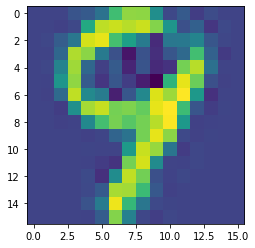

In [ ]:
#traduction de MNIST à USPS
for e in iter(loader_1):
    plt.imshow(GMU(e[0].cuda())[0][0].detach().numpy().reshape(16,16))
    break

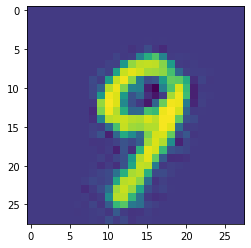

In [ ]:
#Traduction de USPS à MNIST
for e in iter(loader_2):
    plt.imshow(GUM(e[0].cuda())[0][0].cpu().detach().numpy().reshape(28,28))
    break

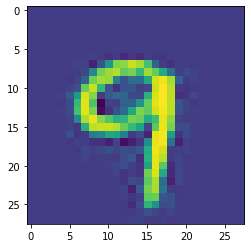

In [ ]:
#cycle MNIST --- > USPS --- > MNIST
for e in iter(loader_1):
    plt.imshow(GUM(GMU(e[0].cuda()))[0][0].cpu().detach().numpy().reshape(28,28))
    break

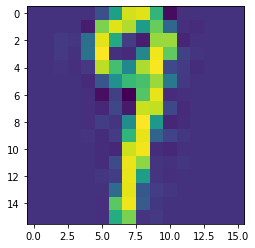

In [ ]:
#cycle USPS --- > MNIST --- > USPS
for e in iter(loader_2):
    plt.imshow(GMU(GUM(e[0]))[0][0].cpu().detach().numpy().reshape(16,16))
    break